In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as opt
import scipy
from tqdm import tqdm
from matplotlib.colors import LogNorm

from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter()

%matplotlib inline
%load_ext autoreload
%autoreload 2

from matplotlib import cm
#import colormaps
#col = [ colormaps.viridis(x) for x in np.linspace(0, 1, 20) ]

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize']=14
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['legend.fancybox'] = True
plt.rcParams['legend.frameon'] = False
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['lines.linewidth'] = 1.
#from matplotlib import rc
#rc('text', usetex=True)

In [2]:
def EnergyRVS(a, size=10.,  x_min=1., x_max=1.e5):
    """Energy Random Variates. Produces a value for energy.
    The energy values are distributing randomly according to 
    a power law PDF.
    """
    y = np.random.uniform(0., 1., size)
    if a==1.:
        norm = np.log(x_max) - np.log(x_min)
        return np.exp(y*norm + np.log(x_min))
    else:
        norm = (x_max**(1.-a) - x_min**(1.-a))
        return(y*norm + x_min**(1.-a))**(1./(1.-a))

def EnergyPDF(x, a, x_min=1., x_max=1.e5):
    """ PDF function for energy, between x_min and x_max
    A power law, with Prob(x) = k x**(-a), for normailsation factor k
    """
    if a==1.:
        norm = np.log(x_max) - np.log(x_min)
    else:
        norm = (x_max**(1.-a) - x_min**(1.-a)) / (1.-a)
    return x**(-a) / norm

def BG_PDF(data):
    """Background PDF (flat)
    """
    return np.ones(len(data)) / 100.

def Sig_PDF_Space(data):
    """Spatial PDF for signal.
    Simple product of Guassians in x and y directions.
    """
    return (scipy.stats.norm.pdf(data['x'], loc=0, scale=data['sigma'])
            * scipy.stats.norm.pdf(data['y'], loc=0, scale=data['sigma']))

def LLh(x):
    """Log likelihood method.
    """
    #Gives ns (signal number) and gamma, the spectral index
    n, gamma = x
    
    #Sig/Bkg PDF equal to the product of spatial and energy PDFs
    S = S_space * EnergyPDF(data['E'], gamma)
    B = B_space * EnergyPDF(data['E'], GammaBG)
    
    #N is total number of events
    N = float(len(S))
    
    #Definition of chi, measures 'signal-ness'
    X  = (S/B-1.)/N
    
    #Equivalent to ns*chi
    alpha = X * n
    
    #Just above -1 to prevent log infinities?   
    aval = -1. + 1.e-10
    
    #Checks each entry in alpha is greater than aval    
    xmask = alpha > aval

    #Returns an new (randomly-filled) array of the same size as alpha
    funval = np.empty_like(alpha, dtype=np.float)
    
    funval[xmask] = np.log1p(alpha[xmask])
    
    #Gives log(1+aval) + (1/aval) * 
    funval[~xmask] = (np.log1p(aval)
                     + 1. / (1.+aval) * (alpha[~xmask] - aval)
                     - 1./2./(1.+aval)**2 * (alpha[~xmask]-aval)**2)
    funval = funval.sum()
    return -2.* funval

In [3]:
#Number of trials, background, signal and sigma
nTrials = 100000 
nBGTrue = 1000
nSig = 20
sigma = .5
sigmaError = 1./1.
#Sets the spectral index of signal and background   
GammaSig = 2.
GammaBG = 4.

#Sets the initial avlues and bounds of the array
initial_values = np.array([0., 0.])
mybounds = [(-0., 80.), (1., 5.)]

n_s = np.array([])
GammaFit = np.array([])
test_stat = np.array([])

#Loops over nTrials (100000) and produces a loading bar 
for i in tqdm(range(nTrials)):
    #Randomly calculates the number of background events using a poisson     
    nBG = np.random.poisson(nBGTrue, 1)
    #Produces randomly-filled arrays , of the form (a,b,c,d), with nBG or nSig entries
    BG = np.empty(nBG, dtype=[('x', np.float), ('y', np.float), ('sigma', np.float), ('E', np.float)])
    Sig = np.empty(nSig, dtype=[('x', np.float), ('y', np.float), ('sigma', np.float), ('E', np.float)])
    
    #Randomly fills the Bkg and sig arrays
    
    BG['x'] = np.random.uniform(-5., 5., nBG)
    BG['y'] = np.random.uniform(-5., 5., nBG)
    BG['sigma'] = np.ones(nBG) * sigma * sigmaError
    BG['E'] = EnergyRVS(GammaBG, size=nBG) 
    Sig['x'] = np.random.normal(0., sigma, nSig)
    Sig['y'] = np.random.normal(0., sigma, nSig)
    Sig['sigma'] = np.ones(nSig) * sigma * sigmaError
    Sig['E'] = EnergyRVS(GammaSig, size=nSig)
    #Merges signal and bkg
    data = np.concatenate( (BG, Sig) )
    
    B_space = BG_PDF(data)
    S_space = Sig_PDF_Space(data)
    
    #Brute force calculation at each grid point of LLH    
    rranges = (slice(-0., 41., 5.), slice(1., 5.25, 1.))
    scan = scipy.optimize.brute(LLh, rranges, full_output=True, finish=None)
    #Minimises function using L-BFGS-B algorithm, with bounds
    res = scipy.optimize.fmin_l_bfgs_b(LLh, scan[0], bounds=mybounds, approx_grad=True)
    #Appends minimised values for n_s, the test statistic and the fitted gamma
    n_s = np.append(n_s, res[0][0])
    GammaFit = np.append(GammaFit, res[0][1])
    test_stat = np.append(test_stat, -res[1]*np.sign(res[0][0]))

    if False:
        plt.figure()
        cp = plt.contourf(scan[2][0], scan[2][1], -scan[3],
                          levels=np.linspace(np.min(-scan[3]), np.max(-scan[3]), 100),
                          cmap=colormaps.viridis, )
#        plt.scatter(scan[0][0], scan[0][1], marker='o', s=50, color='black')
        plt.scatter(res[0][0], res[0][1], marker='o', s=50, color='red')
        plt.grid(True)
        plt.xlim(np.min(scan[2][0]), np.max(scan[2][0]))
        plt.ylim(np.min(scan[2][1]), np.max(scan[2][1]))
        plt.xlabel(r'$n_\mathrm{s}$', fontsize=18)
        plt.ylabel(r'$\gamma$', fontsize=18)
        plt.tight_layout()
        plt.savefig('plots/'+str(i)+'.png', dpi=400)
        plt.savefig('plots/'+str(i)+'.pdf')
        plt.close()

100%|██████████| 100000/100000 [36:08<00:00, 44.66it/s]


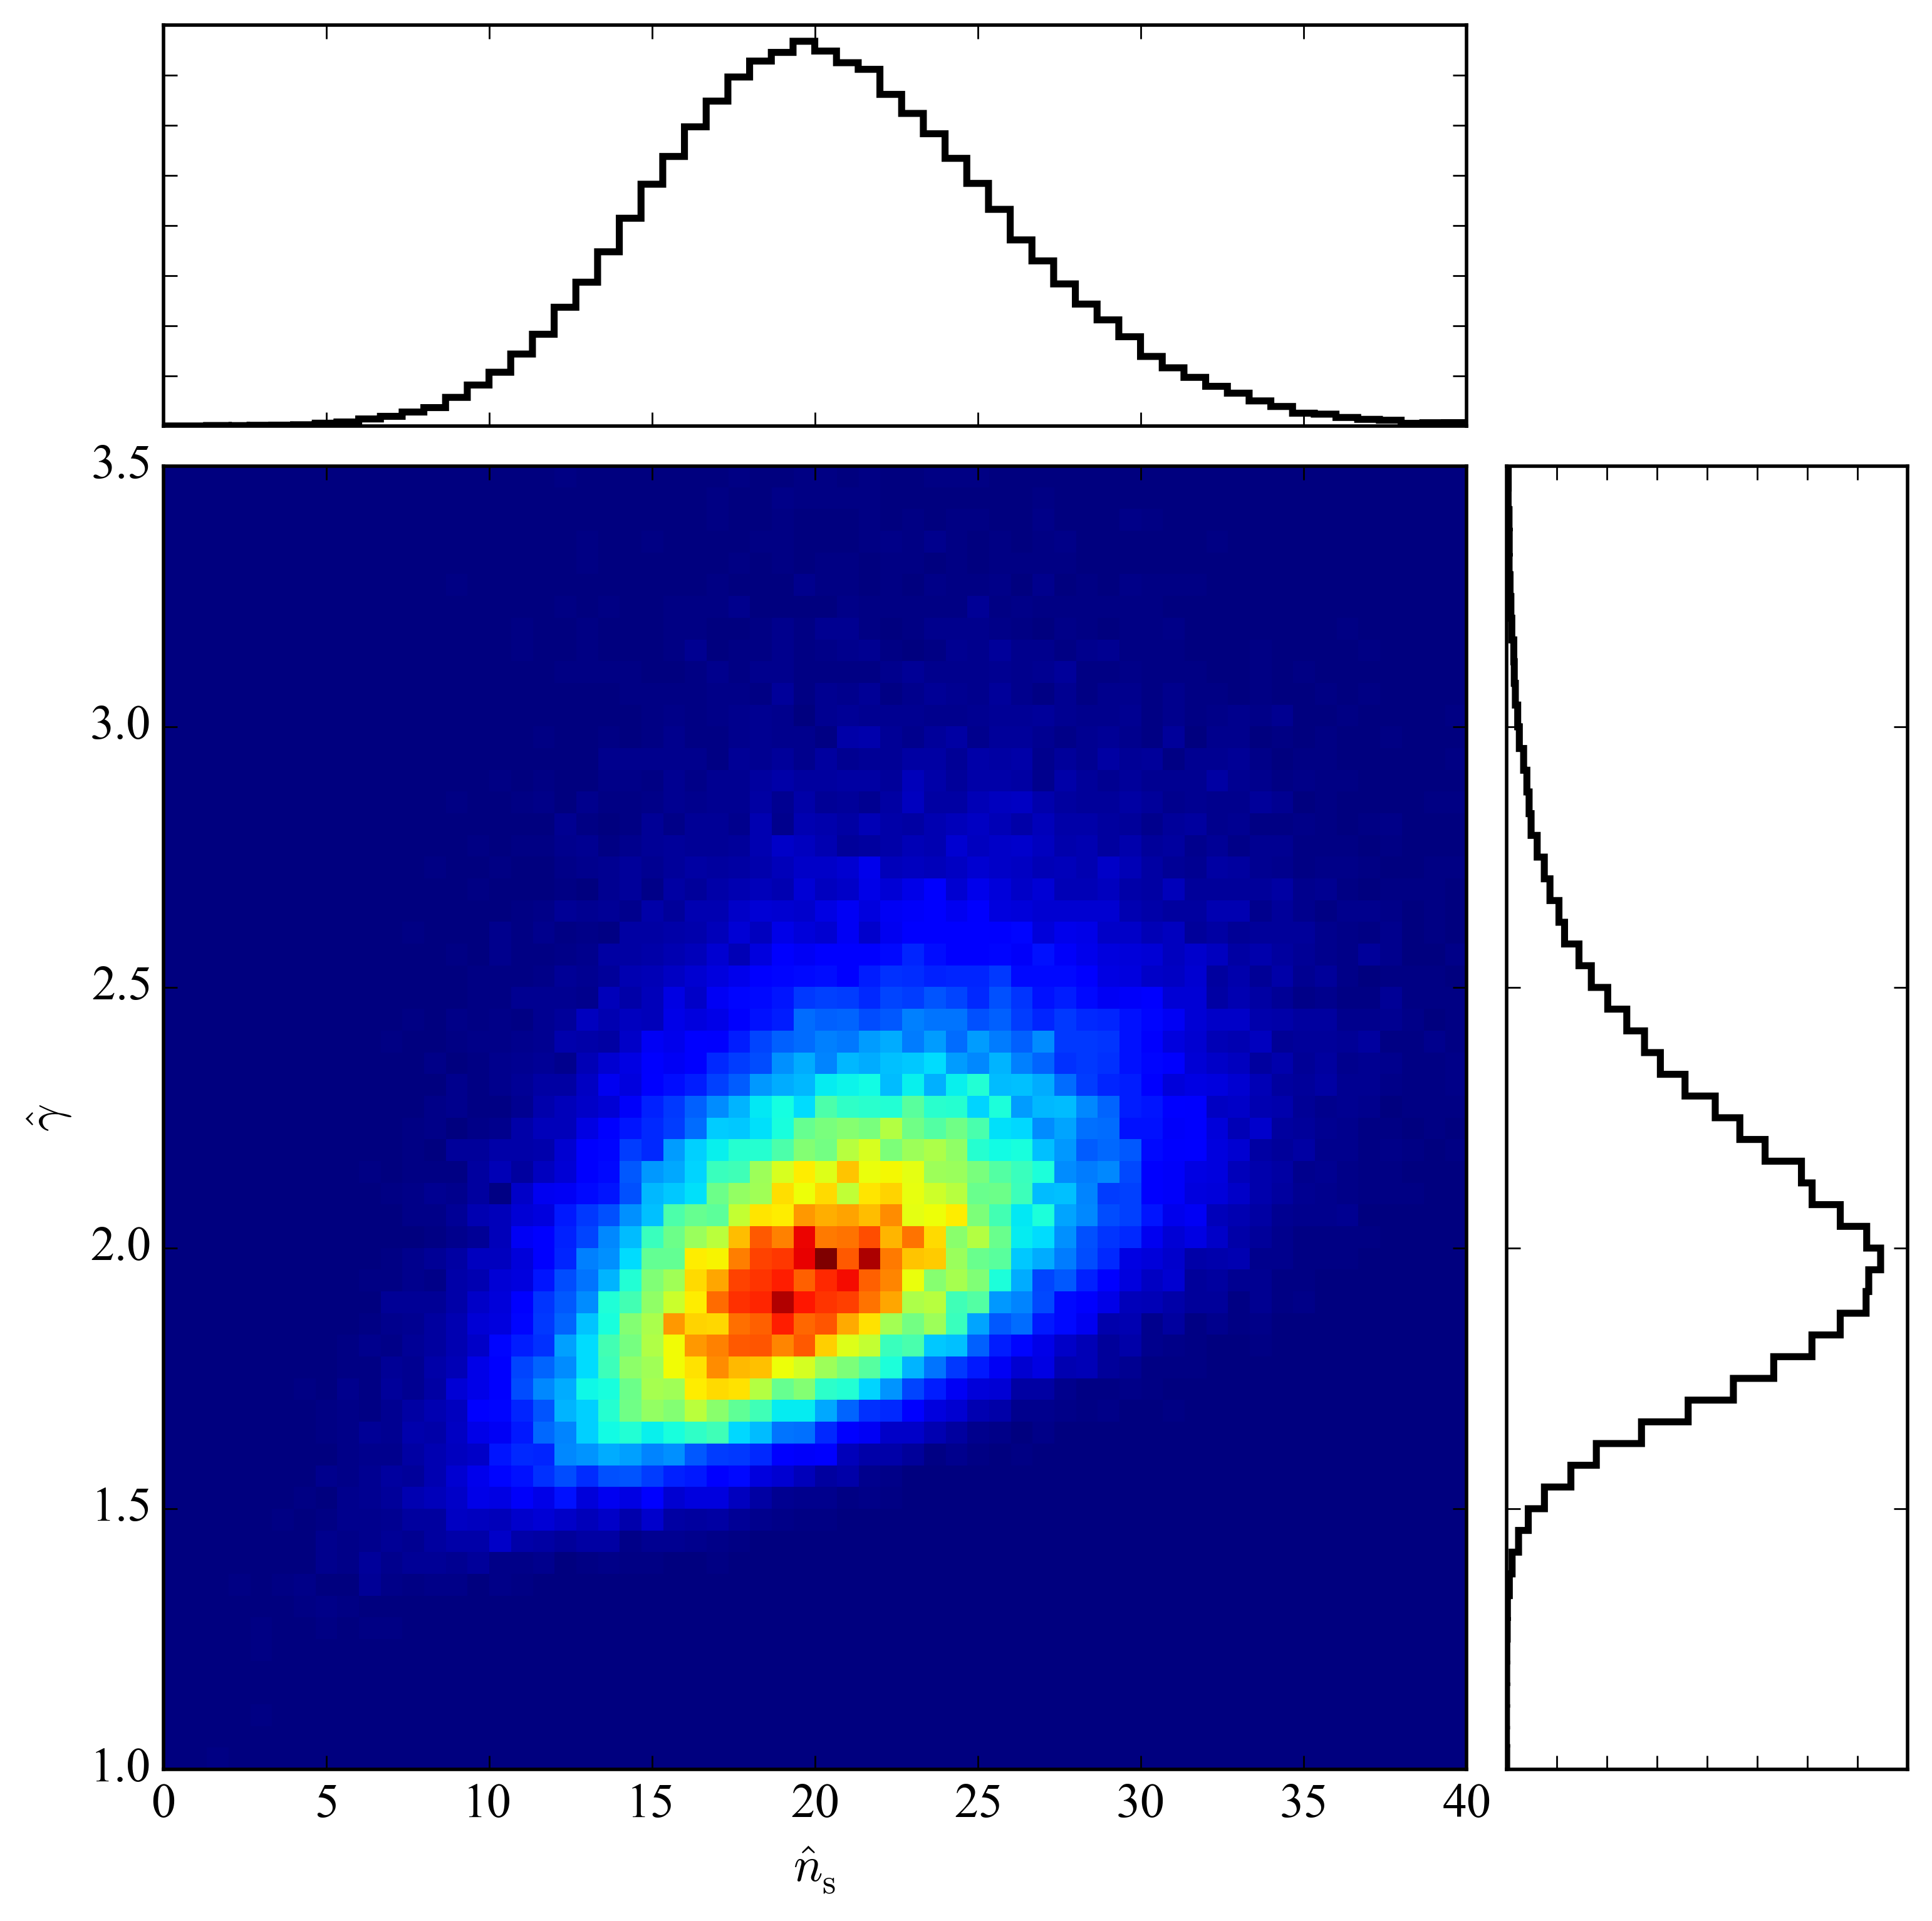

In [4]:
bins = (np.linspace(0., 40., 60+1), np.linspace(1., 3.5, 60+1))

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
f = plt.figure(1, figsize=(8, 8))

axHist = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(nullfmt)
axHisty.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)


axHist.hist2d(n_s, GammaFit, bins=bins)#, norm=LogNorm())
axHist.set_xlabel(r'$\hat{n}_\mathrm{s}$')
axHist.set_ylabel(r'$\hat{\gamma}$')

axHistx.hist(n_s, bins=bins[0], lw=2, histtype='step', color='black', normed=True)
axHisty.hist(GammaFit, bins=bins[1], lw=2, histtype='step', color='black', orientation='horizontal', normed=True)

plt.savefig('plots/Contour.pdf')
plt.show()

In [5]:
#Calculates PMCC values for n_s/gamma. In this case, it's the same as covariance matrix
np.corrcoef(n_s, GammaFit)

array([[ 1.        ,  0.42815091],
       [ 0.42815091,  1.        ]])